In [2]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read the CSV file into a DataFrame
# Note that I extracted the datafile that was "cleaned" during the EDA process
df = pd.read_csv('2_Sales_Data_EDA.csv')

In [4]:
df.head()

,ItemID,year,WeekIdentifier,SalesChannel,Territory,NewBasePrice,SellingStoresRatio,SalesQuantity,revenues,Category,SubCategory,Cat,SubCat,Item
0,te5tHWY15,2018,36,Stores,AXX,21.17,0.0800,4.0,84.68,xF4EZaTy,AunzRwr2,xF4E,Aunz,te5tH
1,te5tHWY15,2018,37,Stores,AXX,21.17,0.0070,4.0,84.68,xF4EZaTy,AunzRwr2,xF4E,Aunz,te5tH
2,yYAY5pI85,2018,38,Stores,YXX,23.33,0.0879,7.0,163.31,HZlnatsW,yo2ZtUyf,HZln,yo2Z,yYAY5
3,yYAY5pI85,2018,38,Stores,AXX,24.08,0.3116,15.0,361.20,HZlnatsW,yo2ZtUyf,HZln,yo2Z,yYAY5
4,Sp6FmlM84,2018,38,Stores,AXX,18.01,0.0908,2.0,36.02,xF4EZaTy,AunzRwr2,xF4E,Aunz,Sp6Fm


In [5]:
#DROP COLUMNS NOT NEEDED
#Drop year & WeekIdentifier columns = no seasonality
#Drop saleschannel = only one entry, filtered to exclude eComm sales, as per project scope
#Drop ItemID, Category and SubCateogry = recall abbreviated entries into new columns
#Drop Cat = choose to model against SubCat
#Drop Revenues = mathematical calculation of SalesQuantity x NewBasePrice

df.drop(columns=['year', 'WeekIdentifier', 'SalesChannel', 'Category', 'Cat', 'SubCategory', 'ItemID', 'revenues'], inplace=True)

In [6]:
df.columns

Index(['Territory', 'NewBasePrice', 'SellingStoresRatio', 'SalesQuantity',
       'SubCat', 'Item'],
      dtype='object')

In [7]:
# Create dummies for SubCat and Territory and assign back to df
df = pd.get_dummies(df, columns=['SubCat', 'Territory'], drop_first=True, prefix=['S', 'T'])

# Check the updated columns
df.columns


Index(['NewBasePrice', 'SellingStoresRatio', 'SalesQuantity', 'Item', 'S_8qIm',
       'S_Aunz', 'S_Mm5P', 'S_OzTP', 'S_UIpu', 'S_WeHS', 'S_qE16', 'S_sldf',
       'S_xdDe', 'S_yo2Z', 'T_YXX'],
      dtype='object')

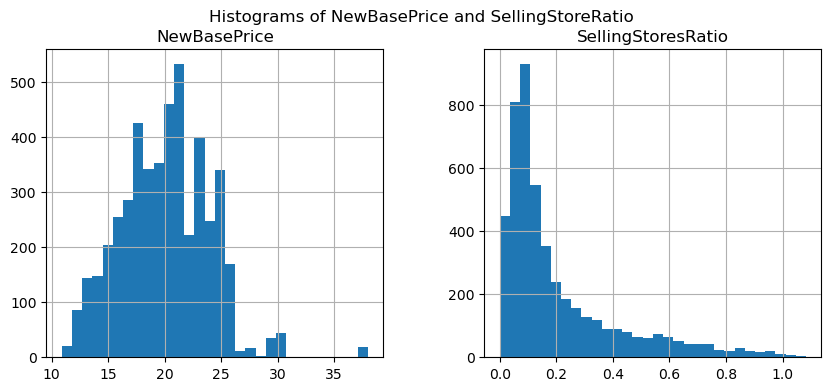

In [22]:
#revisit distribution of NewBasePrice and SellingStoreRatio
# Plot histograms for the two columns
df[['NewBasePrice', 'SellingStoresRatio']].hist(bins=30, figsize=(10, 4))
plt.suptitle('Histograms of NewBasePrice and SellingStoreRatio')
plt.savefig("3_Distribution_of_Features.png", dpi=300, bbox_inches='tight')
plt.show()

**Need to Standardize NewBasePrice and Log transform SellingStoresRatio**
Will do this on Train data

In [9]:
#Split Data to train and test sets
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('SalesQuantity', axis=1)
y = df['SalesQuantity']

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3807, 14)
X_test shape: (952, 14)
y_train shape: (3807,)
y_test shape: (952,)


In [10]:
# DROP the 'Item', from X_train and y_train

X_train.drop(['Item'], axis=1, inplace=True)
X_test.drop(['Item'], axis=1, inplace=True)

In [11]:
# Save the dataframes into cvs files
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [12]:
 from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize 'NewBasePrice' 
scaler = StandardScaler()
X_train['NewBasePrice'] = scaler.fit_transform(X_train[['NewBasePrice']])
X_test['NewBasePrice'] = scaler.transform(X_test[['NewBasePrice']])

# Log-transform 'SellingStoresRatio' 
# Add a small constant to avoid log(0)
X_train['SellingStoresRatio'] = np.log(X_train['SellingStoresRatio'] + 1e-6)
X_test['SellingStoresRatio'] = np.log(X_test['SellingStoresRatio'] + 1e-6)

**In the following sections - separating items that are sensitive to price from those that are not**

In [13]:
# Re-compute correlation between SalesQuantity and NewBasePrice for each Item
corr_df = (
    df.groupby('Item')[['SalesQuantity', 'NewBasePrice']]
      .corr()
      .iloc[0::2, -1]                # Extract correlation of SalesQuantity vs NewBasePrice
      .reset_index()
      .rename(columns={'NewBasePrice': 'corr_price_sales'})
      .drop('level_1', axis=1)
)

# Merge correlation values back to the main dataframe
df = df.merge(corr_df, on='Item', how='left')

# Split into two dataframes based on correlation threshold
df_price_sensitive = df[df['corr_price_sales'] <= -0.6]
df_not_price_sensitive = df[df['corr_price_sales'] > -0.6]

# check the results
print("Price-sensitive items:", df_price_sensitive['Item'].nunique())
print("Other items:", df_not_price_sensitive['Item'].nunique())


Price-sensitive items: 5
Other items: 121


In [14]:
df_not_price_sensitive.shape

(2421, 16)

***Non-price sensitive items = sufficient number of data.  Will follow the same steps done on the original dataframe:  check distribution, split train/test then standardize and log transform, if necessary***

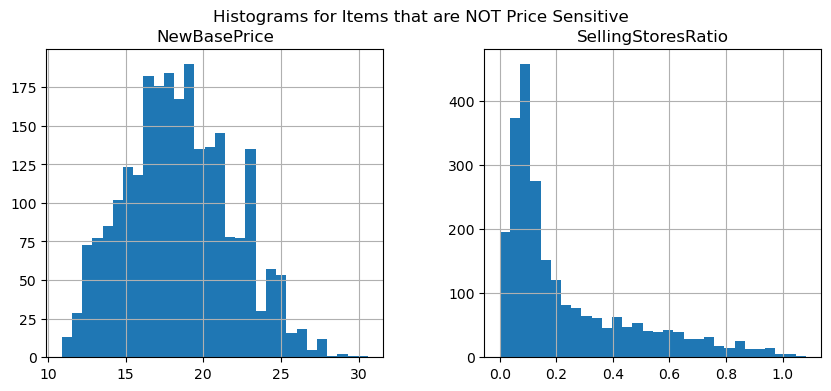

In [15]:
#confirm distribution of NewBasePrice and SellingStoreRatio in Non-price sensitive df
# Plot histograms for the two columns
df_not_price_sensitive[['NewBasePrice', 'SellingStoresRatio']].hist(bins=30, figsize=(10, 4))
plt.suptitle('Histograms for Items that are NOT Price Sensitive')
plt.show()

***Results consistent with original dataset***

In [16]:
#Split Not_price_sensitive Data to train and test sets

# Define features (X) and target (y)
X_nps = df_not_price_sensitive.drop('SalesQuantity', axis=1)
y_nps = df_not_price_sensitive['SalesQuantity']

# Split into training and test sets (80/20 split)
X_nps_train, X_nps_test, y_nps_train, y_nps_test = train_test_split(
    X_nps, y_nps, test_size=0.2, random_state=42
)

# Optional: check the shapes
print("X_nps_train shape:", X_nps_train.shape)
print("X_nps_test shape:", X_nps_test.shape)
print("y_nps_train shape:", y_nps_train.shape)
print("y_nps_test shape:", y_nps_test.shape)

X_nps_train shape: (1936, 15)
X_nps_test shape: (485, 15)
y_nps_train shape: (1936,)
y_nps_test shape: (485,)


In [17]:
# DROP the 'Item'  from X_train and y_train

X_nps_train.drop(['Item'], axis=1, inplace=True)
X_nps_test.drop(['Item'], axis=1, inplace=True)

In [18]:
# Save the dataframes into cvs files
X_nps_train.to_csv('X_nps_train.csv', index=False)
X_nps_test.to_csv('X_nps_test.csv', index=False)
y_nps_train.to_csv('y_nps_train.csv', index=False)
y_nps_test.to_csv('y_nps_test.csv', index=False)

In [19]:
df_price_sensitive.shape

(84, 16)

***Price sensitive items = small data set. Will need to do cross-validation when modelling Price Sensitive data***

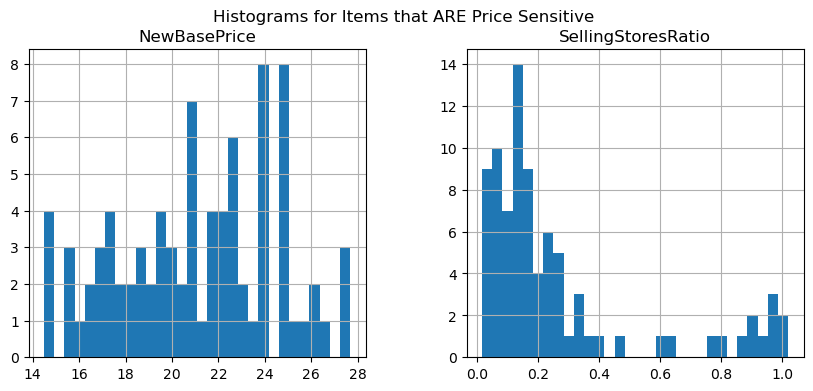

In [20]:
#check distribution of NewBasePrice and SellingStoreRatio in Price sensitive df
# Plot histograms for the two columns
df_price_sensitive[['NewBasePrice', 'SellingStoresRatio']].hist(bins=30, figsize=(10, 4))
plt.suptitle('Histograms for Items that ARE Price Sensitive')
plt.show()

In [21]:
# the distribution is slightly different from the main dataset, 
# but somewhat follow silimiar shape.
# will standardize NewBasePrice and log-transform SellingStoresRatio
# But will do this test during cross validation process (and not prior)

# Separate features (X) and target (y)
X_ps = df_price_sensitive.drop(['SalesQuantity', 'Item'],axis=1)
y_ps = df_price_sensitive['SalesQuantity']

# Save the dataframes into cvs files
X_ps.to_csv('X_ps.csv', index=False)
y_ps.to_csv('y_ps.csv', index=False)
